# Bank Marketing in python using h2o AutoML

More info on H2O AutoML at https://docs.h2o.ai/h2o/latest-stable/h2o-docs/automl.html

Import the required packages

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings(action='ignore', category=DeprecationWarning)

In [2]:
from teradataml.dataframe.copy_to import copy_to_sql
from teradataml.context.context import get_connection
from teradataml.dataframe.dataframe import DataFrame
from teradataml import create_context
import getpass
import h2o
from h2o.automl import H2OAutoML

Replace your cluster details for your user, password, host and database.

In [3]:
engine = create_context(host="3.238.151.85", username="AOA_DEMO", password=getpass.getpass("password"))

password ··········


## Exploratory analysis

Load and inspect the dataset

In [4]:
dataset = DataFrame("bank_marketing_data").to_pandas()
# Visualise a table with the first rows of the dataset, to
# better understand the data format
dataset.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


Check for correlations

In [5]:
corr = dataset.apply(lambda x : pd.factorize(x)[0]).corr(method='pearson', min_periods=1)
corr

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
age,1.000000,0.166402,-0.007715,-0.045936,-0.007067,0.016128,-0.111345,-0.002402,0.050737,0.023363,0.035760,0.026622,-0.010558,0.036239,0.012112,0.045800,0.065228
job,0.166402,1.000000,-0.012186,-0.088132,-0.002168,-0.015648,-0.160040,0.001375,0.024281,0.005493,0.067786,-0.020892,-0.036376,0.024443,0.022966,0.047513,0.068978
marital,-0.007715,-0.012186,1.000000,0.090907,0.049837,-0.026206,-0.027397,-0.014321,-0.031768,0.025010,-0.009086,0.008537,-0.021882,0.009266,-0.001322,-0.000989,0.061242
education,-0.045936,-0.088132,0.090907,1.000000,-0.010534,0.011534,-0.087070,-0.054086,-0.110384,-0.010523,0.072546,-0.012168,0.005049,0.025968,0.027182,0.045689,0.042987
default,-0.007067,-0.002168,0.049837,-0.010534,1.000000,-0.022277,0.006881,0.063994,-0.006654,0.010775,0.013052,-0.039377,-0.012759,-0.028827,-0.028712,-0.031354,0.001303
balance,0.016128,-0.015648,-0.026206,0.011534,-0.022277,1.000000,0.025923,-0.016647,0.018605,-0.007546,-0.012901,0.139572,-0.022156,0.078316,-0.001406,0.006034,0.031489
housing,-0.111345,-0.160040,-0.027397,-0.087070,0.006881,0.025923,1.000000,0.018451,0.097917,-0.048346,-0.300032,0.020312,-0.010403,0.055139,0.046341,0.006302,-0.104683
loan,-0.002402,0.001375,-0.014321,-0.054086,0.063994,-0.016647,0.018451,1.000000,-0.008376,0.049655,0.083930,-0.011070,0.006911,-0.020633,-0.026135,-0.053685,-0.070517
contact,0.050737,0.024281,-0.031768,-0.110384,-0.006654,0.018605,0.097917,-0.008376,1.000000,-0.004404,-0.250411,0.018738,0.032347,-0.132054,-0.123530,-0.149290,-0.082229
day,0.023363,0.005493,0.025010,-0.010523,0.010775,-0.007546,-0.048346,0.049655,-0.004404,1.000000,0.092859,0.003150,0.049538,-0.028044,-0.028344,-0.018421,0.024205


Lets compare the age of the subscribers

67

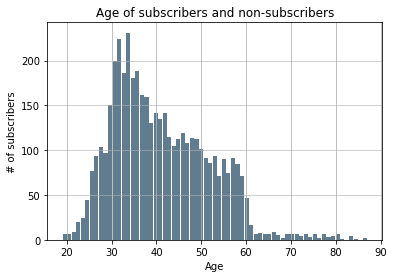

In [6]:
num_bins = dataset['age'].unique().size
dataset['age'].plot.hist(grid=True, bins=num_bins, rwidth=0.9, color='#607c8e')
plt.title('Age of subscribers and non-subscribers')
plt.xlabel('Age')
plt.ylabel('# of subscribers')
plt.grid(axis='y', alpha=0.75)
num_bins

In the histogram above we can see that there is one customer age that is significantly more prevalent than others.

Now we will visualize subscriber percentage by education level, marital status, occupation, and age:

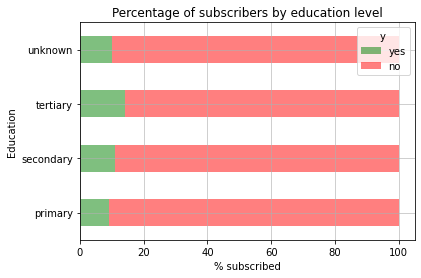

In [7]:
### subscriber % by education level
yn = dataset.groupby(['education', 'y']).size().reset_index(name='counts')
yed = dataset.groupby(['education']).size().reset_index(name='counts')
jed = yn.set_index('education').join(yed.set_index('education'), on='education', how='left', lsuffix='_caller', rsuffix='_other')
jed = jed.assign(perc = (jed['counts_caller']/jed['counts_other']) * 100)
jed = jed.round()
jed = jed.sort_values('y', ascending=True).pivot(columns='y', values='perc')
jed[['yes','no']].plot.barh(stacked=True, color=['Green','Red'], alpha=0.5)
plt.title('Percentage of subscribers by education level')
plt.ylabel('Education')
plt.xlabel('% subscribed')
plt.grid(alpha=0.75)


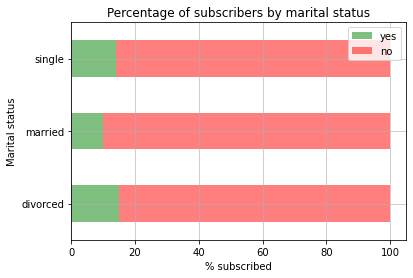

In [8]:
### subscriber % by marital status
yn = dataset.groupby(['marital', 'y']).size().reset_index(name='counts')
yed = dataset.groupby(['marital']).size().reset_index(name='counts')
jed = yn.set_index('marital').join(yed.set_index('marital'), on='marital', how='left', lsuffix='_caller', rsuffix='_other')
jed = jed.assign(perc = (jed['counts_caller']/jed['counts_other']) * 100)
jed = jed.round()
jed = jed.sort_values('y', ascending=True).pivot(columns='y', values='perc')
jed[['yes','no']].plot.barh(stacked=True, color=['Green','Red'], alpha=0.5)
plt.title('Percentage of subscribers by marital status')
plt.ylabel('Marital status')
plt.xlabel('% subscribed')
plt.legend()
plt.grid(alpha=0.75)

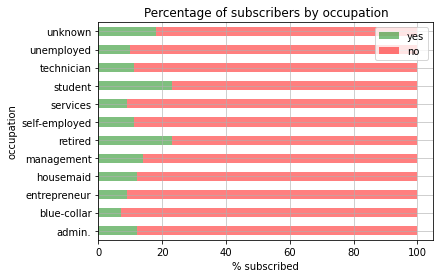

In [9]:
### subscriber by job type
yn = dataset[['job','y']].groupby(['job','y']).size().reset_index(name='counts')
yed = dataset.groupby(['job']).size().reset_index(name='counts')
jed = yn.set_index('job').join(yed.set_index('job'), on='job', how='left', lsuffix='_caller', rsuffix='_other')
jed = jed.assign(perc = (jed['counts_caller']/jed['counts_other']) * 100)
jed = jed.round()
jed = jed.sort_values('y', ascending=True).pivot(columns='y', values='perc')
jed[['yes','no']].plot.barh(stacked=True, color=['Green','Red'], alpha=0.5)
plt.title('Percentage of subscribers by occupation')
plt.ylabel('occupation')
plt.xlabel('% subscribed')
plt.legend()
plt.grid(alpha=0.75)

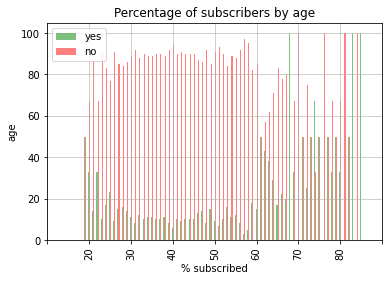

In [10]:
### subscriber by age
yn = dataset[['age','y']].groupby(['age','y']).size().reset_index(name='counts')
yed = dataset.groupby(['age']).size().reset_index(name='counts')
jed = yn.set_index('age').join(yed.set_index('age'), on='age', how='left', lsuffix='_caller', rsuffix='_other')
jed = jed.assign(perc = (jed['counts_caller']/jed['counts_other']) * 100)
jed = jed.round()
jed = jed.sort_values('y', ascending=True).pivot(columns='y', values='perc')
jed[['yes','no']].plot.bar(color=['Green','Red'], alpha=0.5)
plt.title('Percentage of subscribers by age')
plt.ylabel('age')
plt.xlabel('% subscribed')
plt.legend()
plt.xticks([-9,1,11,21,31,41,51,61,71])
plt.grid(alpha=0.75)

## Training 

Upon completing the intial exploratory data analysis, let's run it through AutoML on eight of the columns in the dataset: age, job, marital, education, default, balance, housing, loan.

In [11]:
dataset = DataFrame("bank_marketing_data").select(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'y'])
dataset.head()

   age       job marital  education default balance housing loan    y
0   19   student  single    unknown      no       0      no   no   no
1   20   student  single  secondary      no     502      no   no  yes
2   20   student  single  secondary      no     291      no   no   no
3   20   student  single  secondary      no    1191      no   no   no
4   21  services  single  secondary      no     361      no   no   no
5   21  services  single  secondary      no    1903     yes   no   no
6   21   student  single  secondary      no       6      no   no   no
7   19   student  single  secondary      no     302      no   no  yes
8   19   student  single    unknown      no    1169      no   no   no
9   19   student  single    primary      no     103      no   no  yes

Now we must initialize h2o cluster (locally) and prepare the training dataset

In [12]:
h2o.init()
dataset_hf=h2o.H2OFrame(dataset.to_pandas())

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,2 hours 24 mins
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.34.0.3
H2O_cluster_version_age:,"14 days, 2 hours and 6 minutes"
H2O_cluster_name:,H2O_from_python_unknownUser_jzk9tq
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,662 Mb
H2O_cluster_total_cores:,6
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


We split the training dataset

In [13]:
train,test = dataset_hf.split_frame(ratios=[.7])

Identify predictors and response

In [14]:
x = train.columns
y = 'y'
x.remove(y)

For binary classification, response should be a factor

In [15]:
train[y] = train[y].asfactor()
test[y] = test[y].asfactor()

Run AutoML for 20 base models

In [16]:
aml = H2OAutoML(max_models=20, seed=1)
aml.train(x=x, y=y, training_frame=train)

AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_1_AutoML_1_20211021_135527


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,24.0,24.0,7021.0,6.0,13.0,7.583334,17.0,21.0,18.625




ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.08972734008372056
RMSE: 0.2995452221013057
LogLoss: 0.30843630065766675
Mean Per-Class Error: 0.29004796090490137
AUC: 0.7671464774864207
AUCPR: 0.2957806242603596
Gini: 0.5342929549728415

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.16937073952363713: 


,,no,yes,Error,Rate
0,no,2499.0,325.0,0.1151,(325.0/2824.0)
1,yes,204.0,147.0,0.5812,(204.0/351.0)
2,Total,2703.0,472.0,0.1666,(529.0/3175.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.169371,0.357230,130.0
1,max f2,0.108502,0.509058,235.0
2,max f0point5,0.198458,0.359644,97.0
3,max accuracy,0.336644,0.891024,7.0
4,max precision,0.349636,0.800000,2.0
5,max recall,0.041309,1.000000,376.0
6,max specificity,0.376505,0.999646,0.0
7,max absolute_mcc,0.198458,0.270235,97.0
8,max min_per_class_accuracy,0.119486,0.692308,211.0
9,max mean_per_class_accuracy,0.108502,0.709952,235.0



Gains/Lift Table: Avg response rate: 11.06 %, avg score: 11.11 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010079,0.317974,4.240118,4.240118,0.468750,0.338658,0.468750,0.338658,0.042735,0.042735,324.011752,324.011752,0.036715
1,2,0.020157,0.292715,4.240118,4.240118,0.468750,0.305434,0.468750,0.322046,0.042735,0.085470,324.011752,324.011752,0.073430
2,3,0.031181,0.270316,3.618234,4.020260,0.400000,0.280323,0.444444,0.307295,0.039886,0.125356,261.823362,302.025958,0.105880
3,4,0.040000,0.249800,2.907509,3.774929,0.321429,0.258506,0.417323,0.296539,0.025641,0.150997,190.750916,277.492877,0.124793
4,5,0.050079,0.234806,3.392094,3.697880,0.375000,0.242796,0.408805,0.285723,0.034188,0.185185,239.209402,269.788027,0.151899
5,6,0.100157,0.195284,2.787633,3.242757,0.308176,0.212144,0.358491,0.248934,0.139601,0.324786,178.763282,224.275654,0.252548
6,7,0.150236,0.168241,1.877385,2.787633,0.207547,0.181470,0.308176,0.226446,0.094017,0.418803,87.738537,178.763282,0.301948
7,8,0.200000,0.150630,1.488514,2.464387,0.164557,0.158681,0.272441,0.209585,0.074074,0.492877,48.851383,146.438746,0.329280
8,9,0.300157,0.128318,1.450707,2.126139,0.160377,0.138778,0.235047,0.185958,0.145299,0.638177,45.070688,112.613938,0.380032
9,10,0.400000,0.111370,1.227004,1.901709,0.135647,0.119551,0.210236,0.169382,0.122507,0.760684,22.700351,90.170940,0.405514




ModelMetricsBinomial: gbm
** Reported on cross-validation data. **

MSE: 0.09545899442641963
RMSE: 0.3089643902238891
LogLoss: 0.33379120785650945
Mean Per-Class Error: 0.3952118794540891
AUC: 0.648244998103355
AUCPR: 0.18364307522673048
Gini: 0.29648999620671

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.1402509800751679: 


,,no,yes,Error,Rate
0,no,2176.0,648.0,0.2295,(648.0/2824.0)
1,yes,200.0,151.0,0.5698,(200.0/351.0)
2,Total,2376.0,799.0,0.2671,(848.0/3175.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.140251,0.262609,172.0
1,max f2,0.076326,0.426128,300.0
2,max f0point5,0.191613,0.254391,98.0
3,max accuracy,0.370383,0.889134,0.0
4,max precision,0.305682,0.343750,16.0
5,max recall,0.027816,1.000000,397.0
6,max specificity,0.370383,0.999646,0.0
7,max absolute_mcc,0.187613,0.159799,102.0
8,max min_per_class_accuracy,0.107286,0.598291,233.0
9,max mean_per_class_accuracy,0.116217,0.604788,216.0



Gains/Lift Table: Avg response rate: 11.06 %, avg score: 11.10 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010079,0.303627,3.109420,3.109420,0.343750,0.323108,0.343750,0.323108,0.031339,0.031339,210.941952,210.941952,0.023903
1,2,0.020157,0.277603,2.261396,2.685408,0.250000,0.291325,0.296875,0.307217,0.022792,0.054131,126.139601,168.540776,0.038196
2,3,0.030236,0.259981,2.261396,2.544071,0.250000,0.266583,0.281250,0.293672,0.022792,0.076923,126.139601,154.407051,0.052490
3,4,0.040000,0.244541,1.458965,2.279202,0.161290,0.251255,0.251969,0.283318,0.014245,0.091168,45.896517,127.920228,0.057528
4,5,0.050079,0.229636,2.544071,2.332509,0.281250,0.236193,0.257862,0.273834,0.025641,0.116809,154.407051,133.250909,0.075024
5,6,0.100157,0.191898,2.389400,2.360954,0.264151,0.209495,0.261006,0.241665,0.119658,0.236467,138.939956,136.095433,0.153252
6,7,0.150236,0.171028,1.024028,1.915312,0.113208,0.180999,0.211740,0.221443,0.051282,0.287749,2.402838,91.531235,0.154605
7,8,0.200000,0.153803,1.087760,1.709402,0.120253,0.161618,0.188976,0.206557,0.054131,0.341880,8.776011,70.940171,0.159515
8,9,0.300157,0.128219,1.251590,1.556638,0.138365,0.140372,0.172088,0.184472,0.125356,0.467236,25.159025,55.663776,0.187846
9,10,0.400000,0.109413,1.027259,1.424501,0.113565,0.118933,0.157480,0.168113,0.102564,0.569801,2.725876,42.450142,0.190905




Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,accuracy,0.752441,0.127537,0.823622,0.598425,0.864567,0.629921,0.845669
1,auc,0.641077,0.032549,0.642367,0.606636,0.684640,0.612443,0.659301
2,err,0.247559,0.127537,0.176378,0.401575,0.135433,0.370079,0.154331
3,err_count,157.200000,80.985800,112.000000,255.000000,86.000000,235.000000,98.000000
4,f0point5,0.251047,0.056291,0.283019,0.215736,0.307971,0.170732,0.277778
5,f1,0.277682,0.027674,0.300000,0.285714,0.283333,0.229508,0.289855
6,f2,0.331482,0.060081,0.319149,0.422886,0.262346,0.350000,0.303030
7,lift_top_group,3.145124,1.653335,3.779762,2.212544,2.668067,1.395604,5.669643
8,logloss,0.336077,0.029414,0.339349,0.385259,0.319724,0.325514,0.310538
9,max_per_class_error,0.594154,0.151329,0.666667,0.405063,0.750000,0.461538,0.687500



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error
0,,2021-10-21 13:55:41,4.667 sec,0.0,0.313576,0.347666,0.500000,0.110551,1.000000,0.889449
1,,2021-10-21 13:55:41,4.861 sec,5.0,0.308157,0.331897,0.718740,0.234994,3.101343,0.200945
2,,2021-10-21 13:55:42,5.401 sec,10.0,0.305216,0.323597,0.731489,0.248341,3.109420,0.187402
3,,2021-10-21 13:55:43,6.812 sec,15.0,0.303169,0.317898,0.743508,0.259609,3.109420,0.160315
4,,2021-10-21 13:55:44,7.784 sec,20.0,0.301110,0.312395,0.756493,0.275224,3.957443,0.177638
5,,2021-10-21 13:55:45,8.198 sec,24.0,0.299545,0.308436,0.767146,0.295781,4.240118,0.166614



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,age,34.997467,1.000000,0.258624
1,balance,34.314388,0.980482,0.253576
2,job,26.468029,0.756284,0.195593
3,marital,13.403899,0.382996,0.099052
4,housing,13.003383,0.371552,0.096092
5,education,8.026183,0.229336,0.059312
6,loan,5.108510,0.145968,0.037751
7,default,0.000000,0.000000,0.000000


View the AutoML Leaderboard

In [17]:
lb = aml.leaderboard
lb.head(rows=lb.nrows)

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse
GBM_1_AutoML_1_20211021_135527,0.648245,0.333791,0.183643,0.399631,0.308964,0.095459
StackedEnsemble_BestOfFamily_1_AutoML_1_20211021_135527,0.644994,0.333727,0.196557,0.404669,0.3086,0.0952341
StackedEnsemble_BestOfFamily_2_AutoML_1_20211021_135527,0.642668,0.333988,0.194621,0.405337,0.308788,0.0953502
StackedEnsemble_BestOfFamily_5_AutoML_1_20211021_135527,0.641339,0.33426,0.195503,0.405249,0.308818,0.0953687
StackedEnsemble_AllModels_2_AutoML_1_20211021_135527,0.6408,0.334532,0.191372,0.407664,0.308921,0.0954324
StackedEnsemble_AllModels_1_AutoML_1_20211021_135527,0.640735,0.334178,0.196625,0.416613,0.308689,0.0952889
StackedEnsemble_AllModels_3_AutoML_1_20211021_135527,0.640105,0.334707,0.190073,0.413088,0.308935,0.0954411
StackedEnsemble_AllModels_4_AutoML_1_20211021_135527,0.639719,0.335143,0.189102,0.410054,0.309017,0.0954915
StackedEnsemble_BestOfFamily_8_AutoML_1_20211021_135527,0.639295,0.334157,0.200541,0.407728,0.308683,0.0952854
StackedEnsemble_BestOfFamily_4_AutoML_1_20211021_135527,0.638408,0.335472,0.185441,0.407003,0.309396,0.0957262


The leader model is stored here

In [18]:
model=aml.leader
model

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_1_AutoML_1_20211021_135527


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,24.0,24.0,7021.0,6.0,13.0,7.583334,17.0,21.0,18.625




ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.08972734008372056
RMSE: 0.2995452221013057
LogLoss: 0.30843630065766675
Mean Per-Class Error: 0.29004796090490137
AUC: 0.7671464774864207
AUCPR: 0.2957806242603596
Gini: 0.5342929549728415

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.16937073952363713: 


,,no,yes,Error,Rate
0,no,2499.0,325.0,0.1151,(325.0/2824.0)
1,yes,204.0,147.0,0.5812,(204.0/351.0)
2,Total,2703.0,472.0,0.1666,(529.0/3175.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.169371,0.357230,130.0
1,max f2,0.108502,0.509058,235.0
2,max f0point5,0.198458,0.359644,97.0
3,max accuracy,0.336644,0.891024,7.0
4,max precision,0.349636,0.800000,2.0
5,max recall,0.041309,1.000000,376.0
6,max specificity,0.376505,0.999646,0.0
7,max absolute_mcc,0.198458,0.270235,97.0
8,max min_per_class_accuracy,0.119486,0.692308,211.0
9,max mean_per_class_accuracy,0.108502,0.709952,235.0



Gains/Lift Table: Avg response rate: 11.06 %, avg score: 11.11 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010079,0.317974,4.240118,4.240118,0.468750,0.338658,0.468750,0.338658,0.042735,0.042735,324.011752,324.011752,0.036715
1,2,0.020157,0.292715,4.240118,4.240118,0.468750,0.305434,0.468750,0.322046,0.042735,0.085470,324.011752,324.011752,0.073430
2,3,0.031181,0.270316,3.618234,4.020260,0.400000,0.280323,0.444444,0.307295,0.039886,0.125356,261.823362,302.025958,0.105880
3,4,0.040000,0.249800,2.907509,3.774929,0.321429,0.258506,0.417323,0.296539,0.025641,0.150997,190.750916,277.492877,0.124793
4,5,0.050079,0.234806,3.392094,3.697880,0.375000,0.242796,0.408805,0.285723,0.034188,0.185185,239.209402,269.788027,0.151899
5,6,0.100157,0.195284,2.787633,3.242757,0.308176,0.212144,0.358491,0.248934,0.139601,0.324786,178.763282,224.275654,0.252548
6,7,0.150236,0.168241,1.877385,2.787633,0.207547,0.181470,0.308176,0.226446,0.094017,0.418803,87.738537,178.763282,0.301948
7,8,0.200000,0.150630,1.488514,2.464387,0.164557,0.158681,0.272441,0.209585,0.074074,0.492877,48.851383,146.438746,0.329280
8,9,0.300157,0.128318,1.450707,2.126139,0.160377,0.138778,0.235047,0.185958,0.145299,0.638177,45.070688,112.613938,0.380032
9,10,0.400000,0.111370,1.227004,1.901709,0.135647,0.119551,0.210236,0.169382,0.122507,0.760684,22.700351,90.170940,0.405514




ModelMetricsBinomial: gbm
** Reported on cross-validation data. **

MSE: 0.09545899442641963
RMSE: 0.3089643902238891
LogLoss: 0.33379120785650945
Mean Per-Class Error: 0.3952118794540891
AUC: 0.648244998103355
AUCPR: 0.18364307522673048
Gini: 0.29648999620671

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.1402509800751679: 


,,no,yes,Error,Rate
0,no,2176.0,648.0,0.2295,(648.0/2824.0)
1,yes,200.0,151.0,0.5698,(200.0/351.0)
2,Total,2376.0,799.0,0.2671,(848.0/3175.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.140251,0.262609,172.0
1,max f2,0.076326,0.426128,300.0
2,max f0point5,0.191613,0.254391,98.0
3,max accuracy,0.370383,0.889134,0.0
4,max precision,0.305682,0.343750,16.0
5,max recall,0.027816,1.000000,397.0
6,max specificity,0.370383,0.999646,0.0
7,max absolute_mcc,0.187613,0.159799,102.0
8,max min_per_class_accuracy,0.107286,0.598291,233.0
9,max mean_per_class_accuracy,0.116217,0.604788,216.0



Gains/Lift Table: Avg response rate: 11.06 %, avg score: 11.10 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010079,0.303627,3.109420,3.109420,0.343750,0.323108,0.343750,0.323108,0.031339,0.031339,210.941952,210.941952,0.023903
1,2,0.020157,0.277603,2.261396,2.685408,0.250000,0.291325,0.296875,0.307217,0.022792,0.054131,126.139601,168.540776,0.038196
2,3,0.030236,0.259981,2.261396,2.544071,0.250000,0.266583,0.281250,0.293672,0.022792,0.076923,126.139601,154.407051,0.052490
3,4,0.040000,0.244541,1.458965,2.279202,0.161290,0.251255,0.251969,0.283318,0.014245,0.091168,45.896517,127.920228,0.057528
4,5,0.050079,0.229636,2.544071,2.332509,0.281250,0.236193,0.257862,0.273834,0.025641,0.116809,154.407051,133.250909,0.075024
5,6,0.100157,0.191898,2.389400,2.360954,0.264151,0.209495,0.261006,0.241665,0.119658,0.236467,138.939956,136.095433,0.153252
6,7,0.150236,0.171028,1.024028,1.915312,0.113208,0.180999,0.211740,0.221443,0.051282,0.287749,2.402838,91.531235,0.154605
7,8,0.200000,0.153803,1.087760,1.709402,0.120253,0.161618,0.188976,0.206557,0.054131,0.341880,8.776011,70.940171,0.159515
8,9,0.300157,0.128219,1.251590,1.556638,0.138365,0.140372,0.172088,0.184472,0.125356,0.467236,25.159025,55.663776,0.187846
9,10,0.400000,0.109413,1.027259,1.424501,0.113565,0.118933,0.157480,0.168113,0.102564,0.569801,2.725876,42.450142,0.190905




Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,accuracy,0.752441,0.127537,0.823622,0.598425,0.864567,0.629921,0.845669
1,auc,0.641077,0.032549,0.642367,0.606636,0.684640,0.612443,0.659301
2,err,0.247559,0.127537,0.176378,0.401575,0.135433,0.370079,0.154331
3,err_count,157.200000,80.985800,112.000000,255.000000,86.000000,235.000000,98.000000
4,f0point5,0.251047,0.056291,0.283019,0.215736,0.307971,0.170732,0.277778
5,f1,0.277682,0.027674,0.300000,0.285714,0.283333,0.229508,0.289855
6,f2,0.331482,0.060081,0.319149,0.422886,0.262346,0.350000,0.303030
7,lift_top_group,3.145124,1.653335,3.779762,2.212544,2.668067,1.395604,5.669643
8,logloss,0.336077,0.029414,0.339349,0.385259,0.319724,0.325514,0.310538
9,max_per_class_error,0.594154,0.151329,0.666667,0.405063,0.750000,0.461538,0.687500



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error
0,,2021-10-21 13:55:41,4.667 sec,0.0,0.313576,0.347666,0.500000,0.110551,1.000000,0.889449
1,,2021-10-21 13:55:41,4.861 sec,5.0,0.308157,0.331897,0.718740,0.234994,3.101343,0.200945
2,,2021-10-21 13:55:42,5.401 sec,10.0,0.305216,0.323597,0.731489,0.248341,3.109420,0.187402
3,,2021-10-21 13:55:43,6.812 sec,15.0,0.303169,0.317898,0.743508,0.259609,3.109420,0.160315
4,,2021-10-21 13:55:44,7.784 sec,20.0,0.301110,0.312395,0.756493,0.275224,3.957443,0.177638
5,,2021-10-21 13:55:45,8.198 sec,24.0,0.299545,0.308436,0.767146,0.295781,4.240118,0.166614



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,age,34.997467,1.000000,0.258624
1,balance,34.314388,0.980482,0.253576
2,job,26.468029,0.756284,0.195593
3,marital,13.403899,0.382996,0.099052
4,housing,13.003383,0.371552,0.096092
5,education,8.026183,0.229336,0.059312
6,loan,5.108510,0.145968,0.037751
7,default,0.000000,0.000000,0.000000


## Evaluation

Now we evaluate the predictions against the test dataframe.

In [19]:
preds=model.predict(test)
preds.head()

gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


predict,no,yes
yes,0.786329,0.213671
no,0.863336,0.136664
no,0.951014,0.0489856
no,0.848421,0.151579
no,0.897482,0.102518
no,0.924993,0.0750074
no,0.903158,0.0968416
no,0.863822,0.136178
no,0.879408,0.120592
no,0.874748,0.125252


Evaluate performance

In [20]:
perf=model.model_performance()
perf


ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.08972734008372056
RMSE: 0.2995452221013057
LogLoss: 0.30843630065766675
Mean Per-Class Error: 0.29004796090490137
AUC: 0.7671464774864207
AUCPR: 0.2957806242603596
Gini: 0.5342929549728415

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.16937073952363713: 


,,no,yes,Error,Rate
0,no,2499.0,325.0,0.1151,(325.0/2824.0)
1,yes,204.0,147.0,0.5812,(204.0/351.0)
2,Total,2703.0,472.0,0.1666,(529.0/3175.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.169371,0.357230,130.0
1,max f2,0.108502,0.509058,235.0
2,max f0point5,0.198458,0.359644,97.0
3,max accuracy,0.336644,0.891024,7.0
4,max precision,0.349636,0.800000,2.0
5,max recall,0.041309,1.000000,376.0
6,max specificity,0.376505,0.999646,0.0
7,max absolute_mcc,0.198458,0.270235,97.0
8,max min_per_class_accuracy,0.119486,0.692308,211.0
9,max mean_per_class_accuracy,0.108502,0.709952,235.0



Gains/Lift Table: Avg response rate: 11.06 %, avg score: 11.11 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010079,0.317974,4.240118,4.240118,0.468750,0.338658,0.468750,0.338658,0.042735,0.042735,324.011752,324.011752,0.036715
1,2,0.020157,0.292715,4.240118,4.240118,0.468750,0.305434,0.468750,0.322046,0.042735,0.085470,324.011752,324.011752,0.073430
2,3,0.031181,0.270316,3.618234,4.020260,0.400000,0.280323,0.444444,0.307295,0.039886,0.125356,261.823362,302.025958,0.105880
3,4,0.040000,0.249800,2.907509,3.774929,0.321429,0.258506,0.417323,0.296539,0.025641,0.150997,190.750916,277.492877,0.124793
4,5,0.050079,0.234806,3.392094,3.697880,0.375000,0.242796,0.408805,0.285723,0.034188,0.185185,239.209402,269.788027,0.151899
5,6,0.100157,0.195284,2.787633,3.242757,0.308176,0.212144,0.358491,0.248934,0.139601,0.324786,178.763282,224.275654,0.252548
6,7,0.150236,0.168241,1.877385,2.787633,0.207547,0.181470,0.308176,0.226446,0.094017,0.418803,87.738537,178.763282,0.301948
7,8,0.200000,0.150630,1.488514,2.464387,0.164557,0.158681,0.272441,0.209585,0.074074,0.492877,48.851383,146.438746,0.329280
8,9,0.300157,0.128318,1.450707,2.126139,0.160377,0.138778,0.235047,0.185958,0.145299,0.638177,45.070688,112.613938,0.380032
9,10,0.400000,0.111370,1.227004,1.901709,0.135647,0.119551,0.210236,0.169382,0.122507,0.760684,22.700351,90.170940,0.405514


Explain the model

# Confusion Matrix

> Confusion matrix shows a predicted class vs an actual class.

## GBM_1_AutoML_1_20211021_135527


Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.16018039225490938: 


,,no,yes,Error,Rate
0,no,985.0,191.0,0.1624,(191.0/1176.0)
1,yes,105.0,65.0,0.6176,(105.0/170.0)
2,Total,1090.0,256.0,0.2199,(296.0/1346.0)


# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

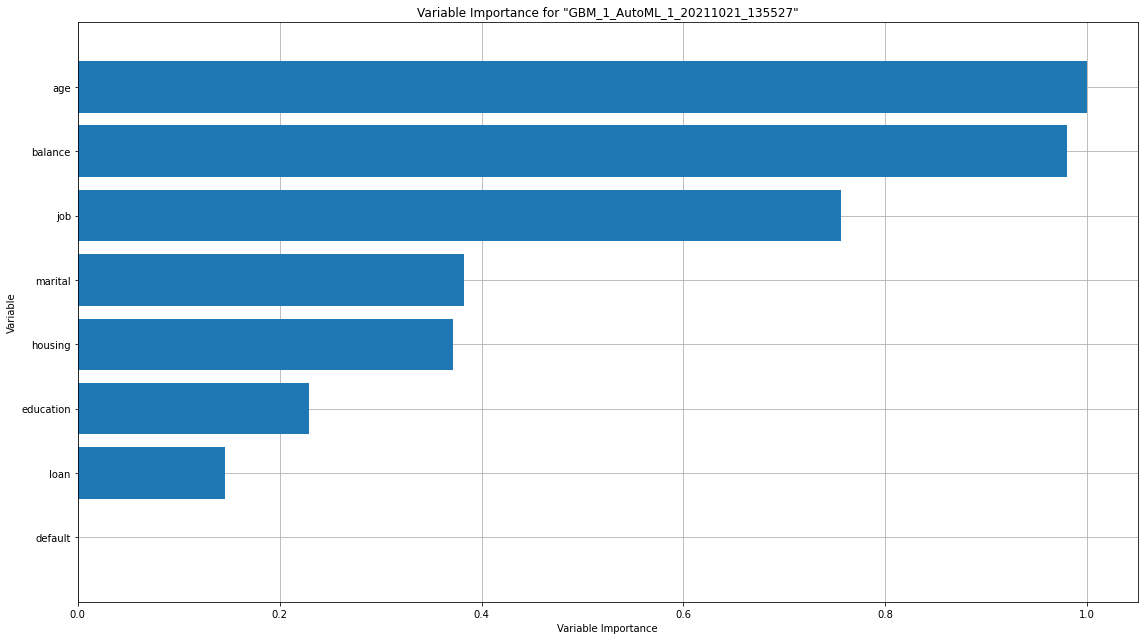

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

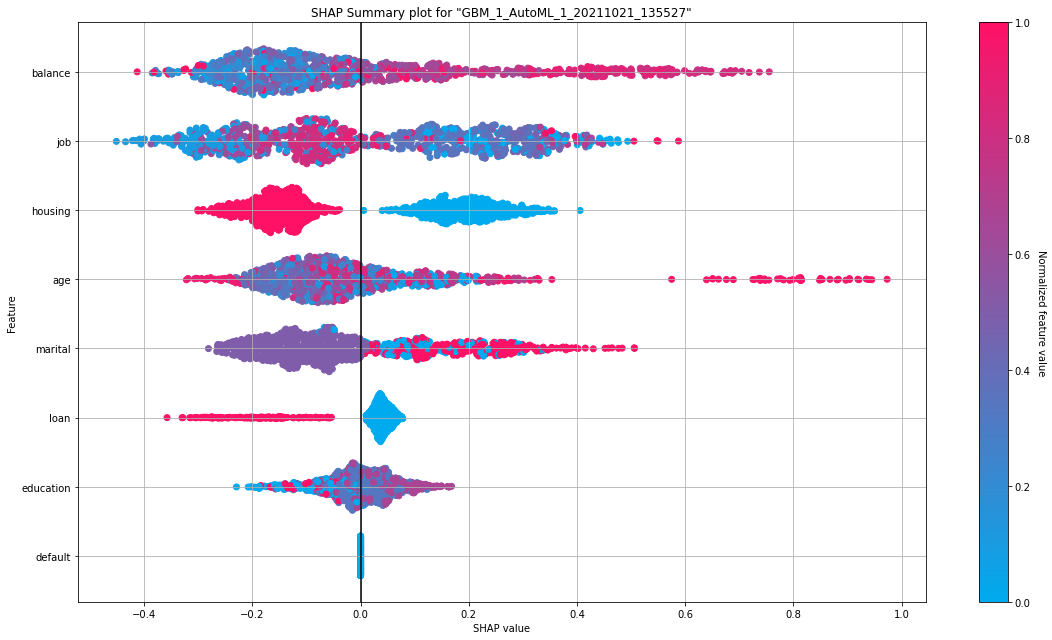

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

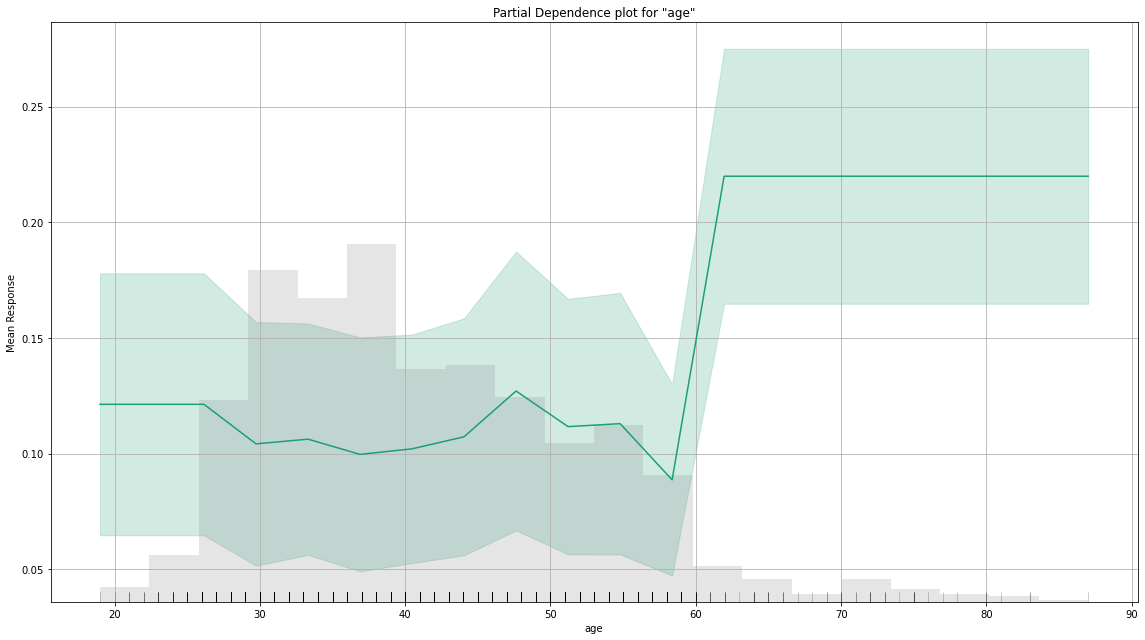

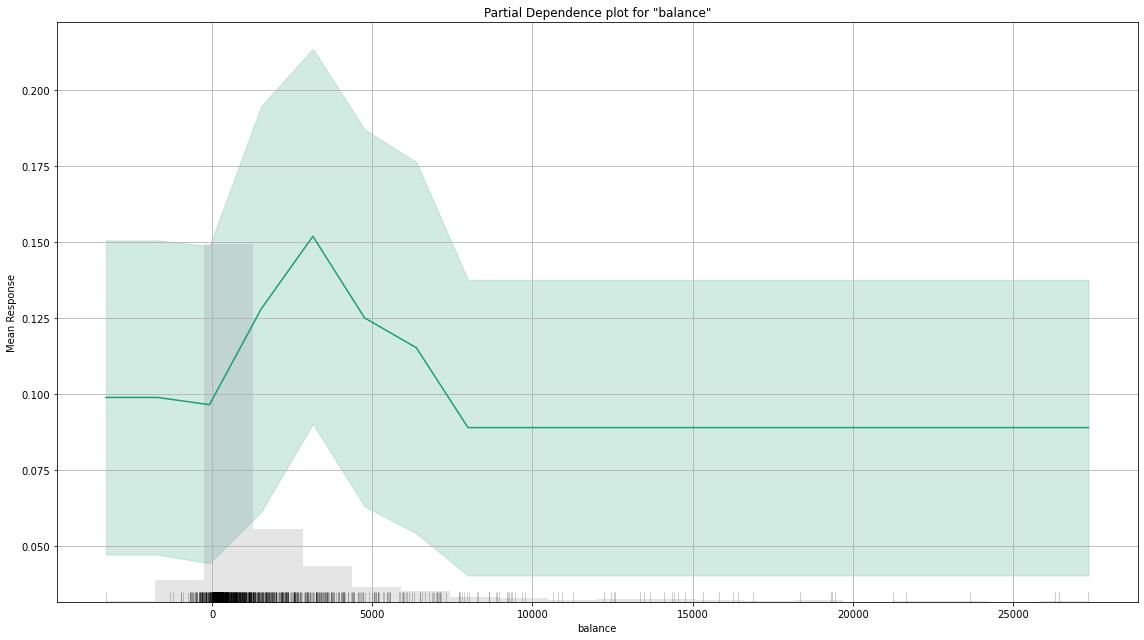

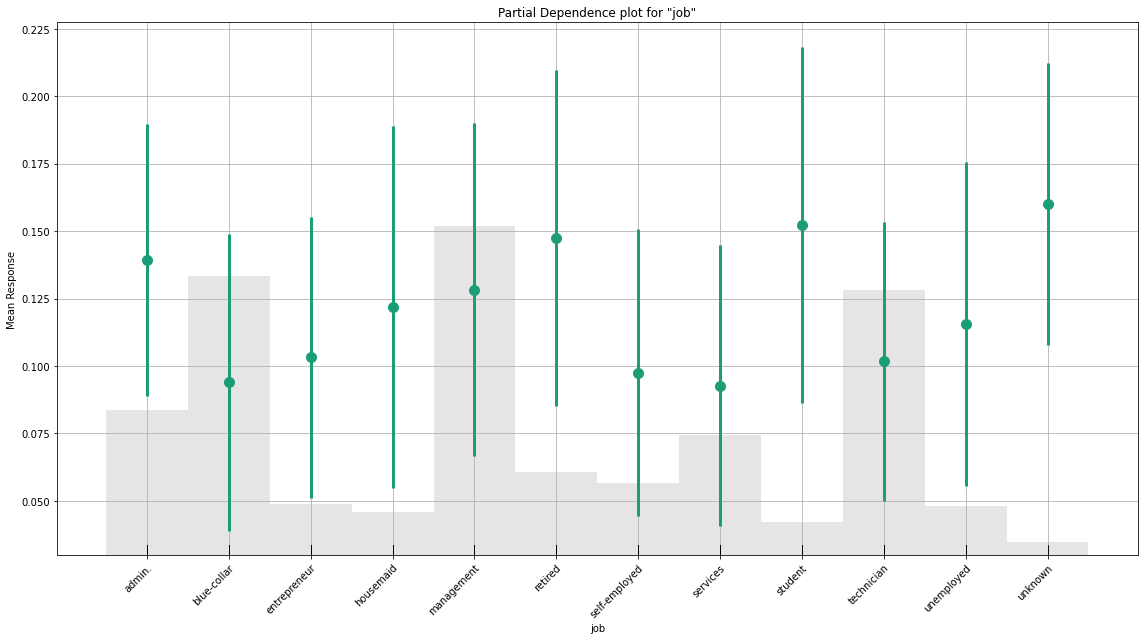

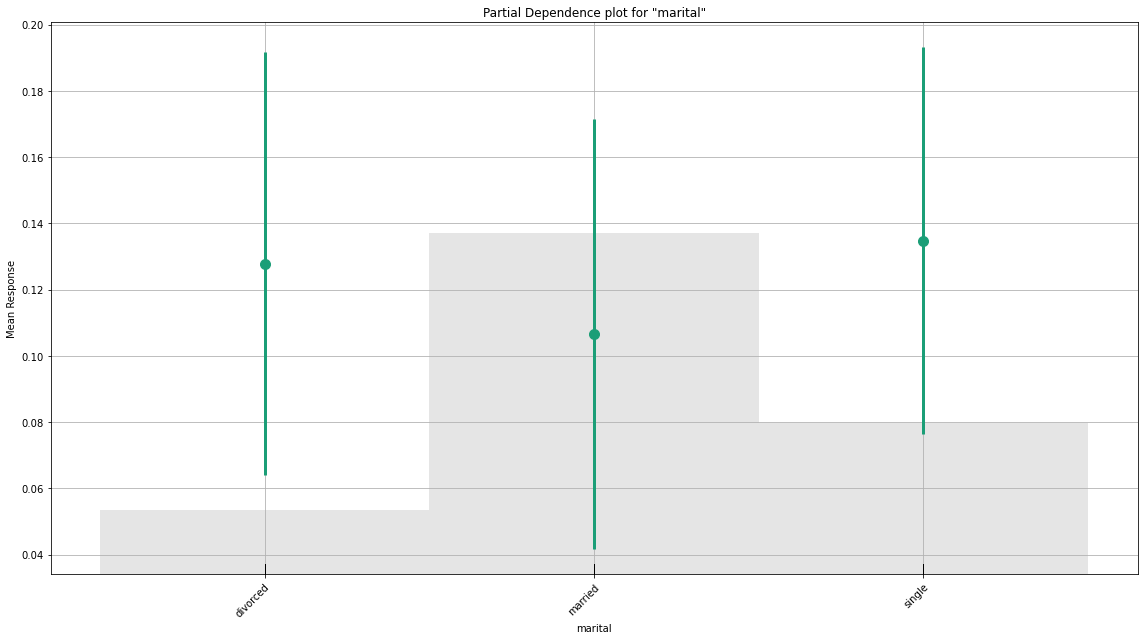

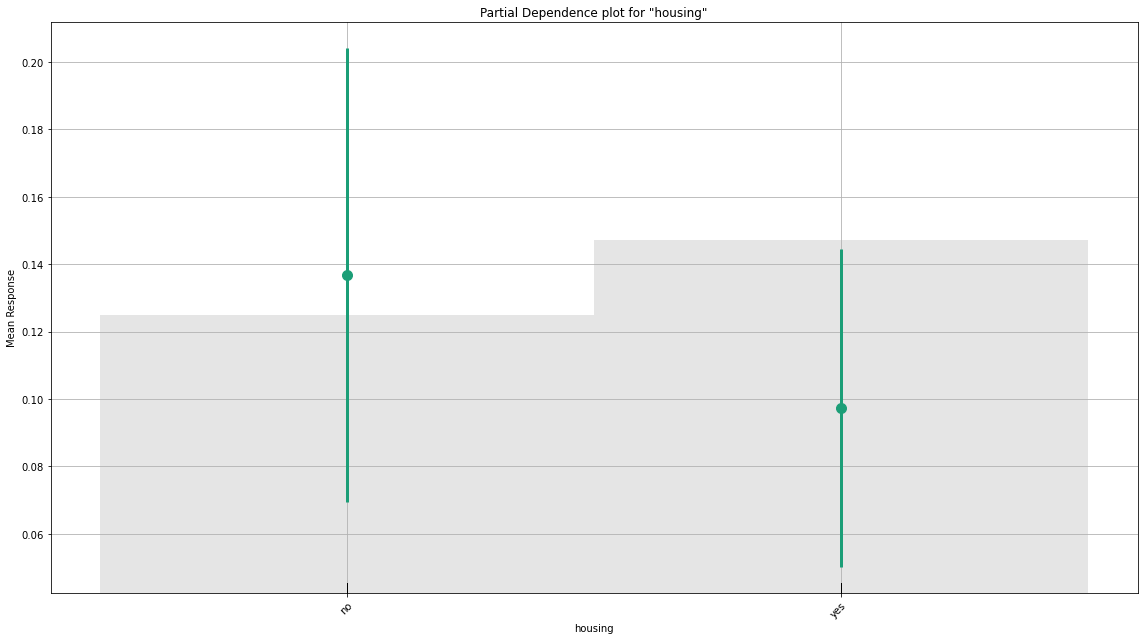

In [21]:
exm=model.explain(test)

Get the variable importance plot

In [22]:
gbm = aml.get_best_model(algorithm="gbm")
fi = gbm.varimp(True)
fix = fi[['variable','scaled_importance']]
fis = fix.to_dict('records')
feature_importance = {v['variable']:v['scaled_importance'] for (k,v) in enumerate(fis)}
feature_importance

{'age': 1.0,
 'balance': 0.9804820513133536,
 'job': 0.7562841331116144,
 'marital': 0.3829962659040789,
 'housing': 0.37155210883007195,
 'education': 0.22933611506657237,
 'loan': 0.14596797918463336,
 'default': 0.0}

In [23]:
gbm.varimp(True)

,variable,relative_importance,scaled_importance,percentage
0,age,34.997467,1.000000,0.258624
1,balance,34.314388,0.980482,0.253576
2,job,26.468029,0.756284,0.195593
3,marital,13.403899,0.382996,0.099052
4,housing,13.003383,0.371552,0.096092
5,education,8.026183,0.229336,0.059312
6,loan,5.108510,0.145968,0.037751
7,default,0.000000,0.000000,0.000000


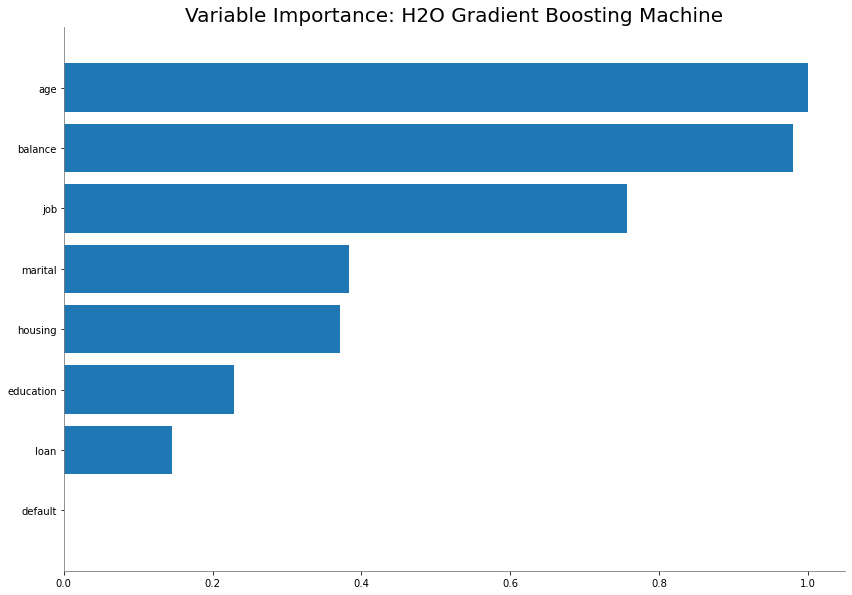

In [24]:
ra_plot = gbm.varimp_plot()

Extract feature interactions:

In [25]:
feature_interactions=gbm.feature_interaction()
feature_interactions


Interaction Depth 0: 


,,interaction,gain,fscore,wfscore,average_wfscore,average_gain,expected_gain,gain_rank,fscore_rank,wfscore_rank,avg_wfscore_rank,avg_gain_rank,expected_gain_rank,average_rank,average_tree_index,average_tree_depth
0,,loan,35.519487,10.0,4.217008,0.421701,3.551949,15.029520,7.0,7.0,7.0,2.0,4.0,7.0,5.666667,10.700000,2.400000
1,,age,337.729532,113.0,29.854488,0.264199,2.988757,280.097659,2.0,2.0,1.0,4.0,5.0,1.0,2.500000,12.221239,4.707965
2,,education,59.090934,39.0,7.479685,0.191787,1.515152,27.224461,6.0,5.0,6.0,7.0,7.0,6.0,6.166667,11.128205,4.179487
3,,balance,424.892988,117.0,27.336378,0.233644,3.631564,277.065302,1.0,1.0,2.0,5.0,3.0,2.0,2.333333,10.102564,3.435897
4,,housing,179.817163,19.0,9.662362,0.508545,9.464061,170.460786,4.0,6.0,4.0,1.0,1.0,4.0,3.333333,10.368421,2.473684
5,,marital,91.437404,41.0,9.499843,0.231703,2.230181,48.711127,5.0,4.0,5.0,6.0,6.0,5.0,5.166667,10.341463,3.341463
6,,job,327.716707,84.0,25.686299,0.305789,3.901389,229.996370,3.0,3.0,3.0,3.0,2.0,3.0,2.833333,13.976190,3.452381



Interaction Depth 1: 


,,interaction,gain,fscore,wfscore,average_wfscore,average_gain,expected_gain,gain_rank,fscore_rank,wfscore_rank,avg_wfscore_rank,avg_gain_rank,expected_gain_rank,average_rank,average_tree_index,average_tree_depth
0,,age|housing,206.197577,11.0,4.223937,0.383994,18.745234,181.596686,7.0,12.0,7.0,2.0,7.0,4.0,6.500000,8.545455,3.909091
1,,age|age,415.832133,41.0,9.975748,0.243311,10.142247,304.985209,2.0,3.0,2.0,13.0,13.0,1.0,5.666667,12.317073,5.097561
2,,job|marital,381.354949,32.0,7.444724,0.232648,11.917342,131.000755,4.0,5.0,5.0,14.0,12.0,6.0,7.666667,12.906250,3.375000
3,,education|housing,112.174829,4.0,1.355906,0.338976,28.043707,44.243605,13.0,20.0,20.0,5.0,3.0,12.0,12.166667,7.250000,2.000000
4,,age|education,7.662745,22.0,2.345197,0.106600,0.348307,0.881323,21.0,8.0,14.0,24.0,23.0,22.0,18.666667,13.227273,6.500000
5,,job|loan,103.525085,6.0,1.842520,0.307087,17.254181,37.031562,14.0,17.0,16.0,8.0,8.0,13.0,12.666667,16.666667,2.833333
6,,job|job,135.247132,9.0,3.127559,0.347507,15.027459,47.724495,11.0,15.0,12.0,4.0,9.0,11.0,10.333333,12.222222,2.888889
7,,balance|job,572.129566,46.0,10.393071,0.225936,12.437599,226.048907,1.0,1.0,1.0,15.0,10.0,2.0,5.000000,13.630435,3.804348
8,,age|marital,6.149834,11.0,1.440945,0.130995,0.559076,0.816119,22.0,13.0,18.0,23.0,22.0,23.0,20.166667,9.818182,5.363636
9,,age|balance,191.254113,16.0,4.159685,0.259980,11.953382,114.750345,8.0,10.0,8.0,12.0,11.0,8.0,9.500000,13.187500,4.500000



See the whole table with table.as_data_frame()

Interaction Depth 2: 


,,interaction,gain,fscore,wfscore,average_wfscore,average_gain,expected_gain,gain_rank,fscore_rank,wfscore_rank,avg_wfscore_rank,avg_gain_rank,expected_gain_rank,average_rank,average_tree_index,average_tree_depth
0,,balance|balance|job,217.844054,16.0,2.019528,0.126220,13.615253,38.423894,8.0,3.0,11.0,40.0,27.0,16.0,17.500000,10.812500,4.437500
1,,age|loan|marital,32.354657,3.0,0.490709,0.163570,10.784886,7.929424,39.0,36.0,39.0,32.0,33.0,36.0,35.833333,4.000000,3.666667
2,,age|age|job,322.950730,21.0,5.249764,0.249989,15.378606,143.039119,4.0,2.0,1.0,14.0,25.0,1.0,7.833333,15.476190,4.666667
3,,balance|job|job,183.332089,12.0,2.307087,0.192257,15.277674,36.506985,11.0,11.0,7.0,23.0,26.0,17.0,15.833333,15.250000,4.000000
4,,balance|balance|balance,120.121495,15.0,1.651654,0.110110,8.008100,12.769031,21.0,5.0,19.0,48.0,36.0,32.0,26.833333,7.400000,4.200000
5,,balance|housing|job,119.451590,5.0,0.987717,0.197543,23.890318,24.255966,22.0,24.0,26.0,21.0,18.0,25.0,22.666667,15.800000,3.600000
6,,age|balance|education,5.960487,5.0,0.512126,0.102425,1.192097,0.840122,43.0,25.0,36.0,49.0,45.0,41.0,39.833333,10.800000,6.200000
7,,balance|education|loan,0.749452,1.0,0.246929,0.246929,0.749452,0.185062,50.0,45.0,49.0,15.0,48.0,49.0,42.666667,5.000000,4.000000
8,,education|housing|job,29.667405,3.0,0.348661,0.116220,9.889135,4.426968,40.0,37.0,42.0,45.0,34.0,39.0,39.500000,14.333333,3.666667
9,,education|job|marital,77.107028,6.0,0.735433,0.122572,12.851171,10.042939,28.0,21.0,30.0,42.0,28.0,33.0,30.333333,15.333333,5.000000



See the whole table with table.as_data_frame()

Interaction Depth 3: 


,,interaction,gain,fscore,wfscore,average_wfscore,average_gain,expected_gain,gain_rank,fscore_rank,wfscore_rank,avg_wfscore_rank,avg_gain_rank,expected_gain_rank,average_rank,average_tree_index,average_tree_depth
0,,balance|education|job|job,121.710117,6.0,0.823937,0.137323,20.285020,20.407161,21.0,10.0,19.0,39.0,41.0,26.0,26.000000,13.833333,4.000000
1,,age|balance|housing|marital,123.234358,2.0,0.413228,0.206614,61.617179,25.457726,20.0,46.0,38.0,16.0,2.0,19.0,23.500000,2.000000,3.500000
2,,age|balance|education|marital,27.991078,2.0,0.181102,0.090551,13.995539,2.488771,56.0,47.0,64.0,71.0,48.0,56.0,57.000000,16.000000,6.000000
3,,age|age|balance|education,4.948547,2.0,0.203465,0.101732,2.474274,0.617338,59.0,48.0,61.0,61.0,60.0,60.0,58.166667,10.000000,6.500000
4,,age|job|loan|marital,1.222376,2.0,0.296378,0.148189,0.611188,0.179112,77.0,49.0,53.0,30.0,81.0,73.0,60.500000,18.000000,7.000000
5,,job|job|job|marital,27.926307,2.0,0.315591,0.157795,13.963153,2.396891,57.0,50.0,51.0,25.0,49.0,58.0,48.333333,15.000000,4.000000
6,,balance|balance|housing|job,31.784408,2.0,0.194646,0.097323,15.892204,3.205975,53.0,51.0,62.0,65.0,44.0,52.0,54.500000,18.000000,4.500000
7,,age|balance|loan|marital,3.926607,1.0,0.095433,0.095433,3.926607,0.374728,61.0,68.0,78.0,67.0,59.0,62.0,65.833333,2.000000,5.000000
8,,age|age|housing|marital,1.650295,2.0,0.142047,0.071024,0.825147,0.117119,71.0,52.0,70.0,81.0,75.0,77.0,71.000000,4.000000,5.500000
9,,balance|education|loan|marital,33.349910,1.0,0.095748,0.095748,33.349910,3.193188,51.0,69.0,77.0,66.0,23.0,53.0,56.500000,6.000000,4.000000



See the whole table with table.as_data_frame()

Interaction Depth 4: 


,,interaction,gain,fscore,wfscore,average_wfscore,average_gain,expected_gain,gain_rank,fscore_rank,wfscore_rank,avg_wfscore_rank,avg_gain_rank,expected_gain_rank,average_rank,average_tree_index,average_tree_depth
0,,age|age|age|balance|balance,50.793812,1.0,0.546142,0.546142,50.793812,27.740622,55.0,57.0,22.0,1.0,18.0,8.0,26.833333,13.000000,4.000000
1,,age|age|age|job|job,179.144077,4.0,0.810079,0.202520,44.786019,24.572465,14.0,13.0,9.0,14.0,24.0,13.0,14.500000,15.500000,5.000000
2,,age|education|job|job|marital,3.347793,3.0,0.303307,0.101102,1.115931,0.314915,73.0,21.0,36.0,56.0,79.0,75.0,56.666667,16.666667,6.333333
3,,age|age|age|balance|job,3.184935,3.0,0.884409,0.294803,1.061645,0.945695,75.0,22.0,8.0,4.0,81.0,71.0,43.500000,22.000000,9.000000
4,,balance|job|job|job|marital,30.943216,1.0,0.103622,0.103622,30.943216,3.206399,60.0,58.0,70.0,52.0,38.0,62.0,56.666667,11.000000,4.000000
5,,balance|education|housing|job|job,29.705014,1.0,0.142677,0.142677,29.705014,4.238227,64.0,59.0,63.0,25.0,46.0,58.0,52.500000,17.000000,4.000000
6,,age|age|balance|job|marital,52.224261,1.0,0.093228,0.093228,52.224261,4.868782,54.0,60.0,75.0,64.0,17.0,53.0,53.833333,3.000000,4.000000
7,,age|balance|education|housing|marital,60.426034,1.0,0.110551,0.110551,60.426034,6.680169,36.0,61.0,68.0,46.0,7.0,42.0,43.333333,0.000000,4.000000
8,,balance|balance|balance|job|marital,149.484099,4.0,0.460157,0.115039,37.371025,18.909863,21.0,14.0,23.0,40.0,29.0,21.0,24.666667,13.250000,4.750000
9,,age|age|job|loan|marital,1.410655,2.0,0.225512,0.112756,0.705328,0.155319,80.0,37.0,50.0,43.0,88.0,81.0,63.166667,18.000000,8.000000



See the whole table with table.as_data_frame()

Interaction Depth 5: 


,,interaction,gain,fscore,wfscore,average_wfscore,average_gain,expected_gain,gain_rank,fscore_rank,wfscore_rank,avg_wfscore_rank,avg_gain_rank,expected_gain_rank,average_rank,average_tree_index,average_tree_depth
0,,age|age|balance|job|job|marital,52.356487,1.0,0.087244,0.087244,52.356487,4.567794,45.0,35.0,54.0,48.0,25.0,43.0,41.666667,3.000000,5.00
1,,age|age|age|age|age|job,117.943038,2.0,0.625197,0.312598,58.971519,36.862260,12.0,17.0,6.0,2.0,15.0,2.0,9.000000,23.000000,5.50
2,,age|age|balance|balance|education|job,55.229044,4.0,0.668346,0.167087,13.807261,15.771922,39.0,5.0,5.0,13.0,57.0,16.0,22.500000,15.250000,8.00
3,,age|age|age|education|housing|marital,242.943733,4.0,0.365984,0.091496,60.735933,22.217183,2.0,6.0,15.0,44.0,12.0,9.0,14.666667,0.000000,5.50
4,,age|balance|balance|balance|job|job,267.036345,6.0,0.770079,0.128346,44.506058,36.706306,1.0,1.0,2.0,21.0,29.0,3.0,9.500000,16.666667,5.50
5,,age|balance|balance|education|job|marital,54.040270,2.0,0.185197,0.092598,27.020135,6.177170,42.0,18.0,32.0,42.0,51.0,33.0,36.333333,21.000000,6.50
6,,age|age|education|job|job|marital,1.771481,2.0,0.140472,0.070236,0.885740,0.125421,61.0,19.0,39.0,67.0,72.0,68.0,54.333333,18.000000,8.00
7,,age|balance|education|job|job|marital,115.118299,2.0,0.162835,0.081417,57.559150,9.371971,14.0,20.0,35.0,53.0,19.0,24.0,27.500000,16.000000,6.00
8,,age|age|job|job|loan|marital,60.192613,4.0,0.682520,0.170630,15.048153,20.780832,33.0,7.0,4.0,12.0,56.0,10.0,20.333333,18.000000,7.50
9,,age|age|age|housing|job|job,240.868602,4.0,0.479685,0.119921,60.217151,29.153761,3.0,8.0,11.0,25.0,14.0,6.0,11.166667,5.500000,5.25



See the whole table with table.as_data_frame()

Interaction Depth 6: 


,,interaction,gain,fscore,wfscore,average_wfscore,average_gain,expected_gain,gain_rank,fscore_rank,wfscore_rank,avg_wfscore_rank,avg_gain_rank,expected_gain_rank,average_rank,average_tree_index,average_tree_depth
0,,age|balance|balance|balance|education|job|marital,106.506060,2.0,0.185197,0.092598,53.253030,9.862169,10.0,8.0,16.0,25.0,17.0,14.0,15.000000,21.000000,6.500000
1,,age|balance|balance|balance|job|job|job,53.176934,1.0,0.087874,0.087874,53.176934,4.672871,25.0,17.0,32.0,29.0,18.0,29.0,25.000000,21.000000,7.000000
2,,age|age|age|housing|job|job|marital,62.960349,1.0,0.075906,0.075906,62.960349,4.779038,16.0,18.0,37.0,36.0,3.0,27.0,22.833333,4.000000,6.000000
3,,age|balance|balance|balance|housing|job|loan,52.641933,1.0,0.154331,0.154331,52.641933,8.124266,30.0,19.0,22.0,9.0,24.0,20.0,20.666667,19.000000,6.000000
4,,age|age|age|balance|housing|job|loan,53.438754,1.0,0.063622,0.063622,53.438754,3.399883,24.0,20.0,44.0,44.0,16.0,35.0,30.500000,19.000000,7.000000
5,,age|age|age|balance|job|job|job,1.599501,1.0,0.318425,0.318425,1.599501,0.509321,39.0,21.0,6.0,2.0,38.0,37.0,23.833333,22.000000,9.000000
6,,age|age|age|age|balance|job|job,102.185457,3.0,1.085984,0.361995,34.061819,44.970569,13.0,4.0,1.0,1.0,28.0,1.0,8.000000,22.000000,7.666667
7,,age|age|age|age|balance|education|job,2.301121,2.0,0.240630,0.120315,1.150560,0.282431,37.0,9.0,10.0,15.0,42.0,38.0,25.166667,22.000000,11.500000
8,,age|age|age|age|education|housing|marital,121.198242,2.0,0.146457,0.073228,60.599121,8.875093,5.0,10.0,24.0,40.0,7.0,18.0,17.333333,0.000000,6.000000
9,,age|age|age|age|housing|job|job,126.139797,2.0,0.176063,0.088031,63.069899,11.103802,4.0,11.0,18.0,28.0,2.0,10.0,12.166667,4.000000,6.500000



See the whole table with table.as_data_frame()

Interaction Depth 7: 


,,interaction,gain,fscore,wfscore,average_wfscore,average_gain,expected_gain,gain_rank,fscore_rank,wfscore_rank,avg_wfscore_rank,avg_gain_rank,expected_gain_rank,average_rank,average_tree_index,average_tree_depth
0,,age|age|age|age|balance|balance|job|job,52.113689,2.0,0.452283,0.226142,26.056844,18.701234,20.0,4.0,3.0,3.0,25.0,4.0,9.833333,22.0,9.500000
1,,age|balance|balance|balance|balance|education|job|marital,53.255803,1.0,0.070236,0.070236,53.255803,3.740486,16.0,8.0,28.0,28.0,15.0,20.0,19.166667,21.0,7.000000
2,,balance|balance|education|job|job|loan|marital|marital,61.660255,1.0,0.127244,0.127244,61.660255,7.845904,8.0,9.0,12.0,8.0,4.0,8.0,8.166667,20.0,7.000000
3,,age|age|balance|balance|balance|housing|job|loan,52.829298,1.0,0.083780,0.083780,52.829298,4.426014,18.0,10.0,21.0,21.0,17.0,16.0,17.166667,19.0,7.000000
4,,age|age|age|age|balance|job|job|job,1.713629,1.0,0.199370,0.199370,1.713629,0.341646,28.0,11.0,10.0,5.0,27.0,27.0,18.000000,22.0,10.000000
5,,age|age|age|age|age|balance|job|job,50.483000,1.0,0.412283,0.412283,50.483000,20.813306,23.0,12.0,5.0,1.0,21.0,3.0,10.833333,22.0,7.000000
6,,age|age|age|age|age|age|job|marital,59.198805,1.0,0.238110,0.238110,59.198805,14.095841,10.0,13.0,7.0,2.0,7.0,7.0,7.666667,23.0,7.000000
7,,age|balance|balance|education|education|housing|loan|marital,30.444937,1.0,0.112441,0.112441,30.444937,3.423258,25.0,14.0,13.0,10.0,24.0,23.0,18.166667,5.0,7.000000
8,,age|balance|education|job|job|loan|marital|marital,61.966410,1.0,0.092283,0.092283,61.966410,5.718475,6.0,15.0,18.0,18.0,2.0,10.0,11.500000,20.0,8.000000
9,,age|age|age|balance|balance|balance|job|job,51.225471,1.0,0.080945,0.080945,51.225471,4.146440,22.0,16.0,23.0,23.0,20.0,19.0,20.500000,13.0,7.000000



See the whole table with table.as_data_frame()

Interaction Depth 8: 


,,interaction,gain,fscore,wfscore,average_wfscore,average_gain,expected_gain,gain_rank,fscore_rank,wfscore_rank,avg_wfscore_rank,avg_gain_rank,expected_gain_rank,average_rank,average_tree_index,average_tree_depth
0,,age|age|age|age|age|age|job|job|marital,118.757404,2.0,0.238110,0.119055,59.378702,14.140481,1.0,2.0,3.0,5.0,3.0,3.0,2.833333,23.0,8.0
1,,age|balance|balance|education|job|job|loan|marital|marital,61.966410,1.0,0.092283,0.092283,61.966410,5.718475,5.0,7.0,11.0,9.0,1.0,9.0,7.000000,20.0,8.0
2,,age|age|age|age|balance|balance|education|job|job,1.408857,1.0,0.074331,0.074331,1.408857,0.104721,14.0,8.0,14.0,13.0,14.0,15.0,13.000000,22.0,12.0
3,,age|age|age|age|age|balance|education|job|job,1.388938,1.0,0.083150,0.083150,1.388938,0.115490,15.0,9.0,12.0,11.0,15.0,14.0,12.666667,22.0,12.0
4,,age|age|age|age|education|job|job|job|marital,116.267178,2.0,0.140472,0.070236,58.133589,8.167167,3.0,3.0,8.0,15.0,5.0,6.0,6.666667,18.0,8.0
5,,age|age|age|job|job|job|job|loan|marital,58.101293,1.0,0.101732,0.101732,58.101293,5.910777,8.0,10.0,10.0,7.0,6.0,8.0,8.166667,18.0,9.0
6,,age|age|age|balance|balance|balance|job|job|job,2.056941,1.0,0.119055,0.119055,2.056941,0.244889,12.0,11.0,9.0,4.0,12.0,13.0,10.166667,22.0,10.0
7,,age|age|age|age|job|job|job|loan|marital,116.268317,2.0,0.225512,0.112756,58.134159,13.106199,2.0,4.0,4.0,6.0,4.0,4.0,4.000000,18.0,8.0
8,,age|age|age|age|age|balance|balance|job|job,50.674322,1.0,0.366614,0.366614,50.674322,18.577924,10.0,12.0,2.0,1.0,8.0,1.0,5.666667,22.0,8.0
9,,age|age|balance|balance|education|education|housing|loan|marital,30.462368,1.0,0.074961,0.074961,30.462368,2.283479,11.0,13.0,13.0,12.0,10.0,11.0,11.666667,5.0,8.0



Interaction Depth 9: 


,,interaction,gain,fscore,wfscore,average_wfscore,average_gain,expected_gain,gain_rank,fscore_rank,wfscore_rank,avg_wfscore_rank,avg_gain_rank,expected_gain_rank,average_rank,average_tree_index,average_tree_depth
0,,age|age|age|age|balance|balance|balance|job|job|job,53.069809,2.0,0.204724,0.102362,26.534905,6.247903,4.0,1.0,3.0,3.0,4.0,3.0,3.000000,22.0,10.5
1,,age|age|age|age|job|job|job|job|loan|marital,58.101293,1.0,0.101732,0.101732,58.101293,5.910777,3.0,5.0,5.0,4.0,2.0,4.0,3.833333,18.0,9.0
2,,age|age|age|age|age|balance|balance|job|job|job,101.700886,2.0,0.517795,0.258898,50.850443,26.323324,2.0,2.0,1.0,1.0,3.0,1.0,1.666667,22.0,9.5
3,,age|age|age|age|age|balance|education|job|job|job,1.768561,1.0,0.083150,0.083150,1.768561,0.147055,6.0,6.0,6.0,6.0,6.0,6.0,6.000000,22.0,12.0
4,,age|age|age|age|age|age|education|job|job|marital,118.842732,2.0,0.201890,0.100945,59.421366,11.996071,1.0,3.0,4.0,5.0,1.0,2.0,2.666667,23.0,9.5
5,,age|age|age|age|balance|balance|education|job|job|job,3.837607,2.0,0.231811,0.115906,1.918804,0.455636,5.0,4.0,2.0,2.0,5.0,5.0,3.833333,22.0,11.5



Interaction Depth 10: 


,,interaction,gain,fscore,wfscore,average_wfscore,average_gain,expected_gain,gain_rank,fscore_rank,wfscore_rank,avg_wfscore_rank,avg_gain_rank,expected_gain_rank,average_rank,average_tree_index,average_tree_depth
0,,age|age|age|age|age|age|age|education|job|job|marital,59.430985,1.0,0.075276,0.075276,59.430985,4.473702,2.0,3.0,4.0,4.0,1.0,4.0,3.000000,23.0,10.0
1,,age|age|age|age|age|balance|balance|education|job|job|job,53.011566,2.0,0.240630,0.120315,26.505783,8.195445,3.0,1.0,1.0,2.0,4.0,3.0,2.333333,22.0,11.5
2,,age|age|age|age|age|balance|balance|balance|job|job|job,101.976136,2.0,0.204724,0.102362,50.988068,10.437673,1.0,2.0,2.0,3.0,2.0,1.0,1.833333,22.0,10.5
3,,age|age|age|age|age|age|balance|balance|job|job|job,50.907507,1.0,0.199370,0.199370,50.907507,10.149433,4.0,4.0,3.0,1.0,3.0,2.0,2.833333,22.0,10.0
4,,age|age|age|age|balance|balance|balance|education|job|job|job,2.076033,1.0,0.074331,0.074331,2.076033,0.154313,5.0,5.0,5.0,5.0,5.0,5.0,5.000000,22.0,12.0



Interaction Depth 11: 


,,interaction,gain,fscore,wfscore,average_wfscore,average_gain,expected_gain,gain_rank,fscore_rank,wfscore_rank,avg_wfscore_rank,avg_gain_rank,expected_gain_rank,average_rank,average_tree_index,average_tree_depth
0,,age|age|age|age|age|age|balance|balance|balance|job|job|job,51.012868,1.0,0.085669,0.085669,51.012868,4.370236,2.0,2.0,2.0,2.0,1.0,2.0,1.833333,22.0,11.0
1,,age|age|age|age|age|age|balance|balance|education|job|job|job,101.917892,2.0,0.240630,0.120315,50.958946,12.261986,1.0,1.0,1.0,1.0,3.0,1.0,1.333333,22.0,11.5
2,,age|age|age|age|age|balance|balance|balance|education|job|job|job,50.982359,1.0,0.074331,0.074331,50.982359,3.789555,3.0,3.0,3.0,3.0,2.0,3.0,2.833333,22.0,12.0



Interaction Depth 12: 


,,interaction,gain,fscore,wfscore,average_wfscore,average_gain,expected_gain,gain_rank,fscore_rank,wfscore_rank,avg_wfscore_rank,avg_gain_rank,expected_gain_rank,average_rank,average_tree_index,average_tree_depth
0,,age|age|age|age|age|age|balance|balance|balance|education|job|job|job,50.982359,1.0,0.074331,0.074331,50.982359,3.789555,1.0,1.0,2.0,2.0,1.0,2.0,1.5,22.0,12.0
1,,age|age|age|age|age|age|age|balance|balance|education|job|job|job,50.962440,1.0,0.083150,0.083150,50.962440,4.237506,2.0,2.0,1.0,1.0,2.0,1.0,1.5,22.0,12.0



Leaf Statistics: 


,,interaction,sum_leaf_values_left,sum_leaf_values_right,sum_leaf_covers_left,sum_leaf_covers_right
0,,balance|education|job|job,-0.036338,0.035015,162.0,300.0
1,,age|age|age|age|age|age|job|job|marital,-0.117874,0.012629,209.0,145.0
2,,age|balance|housing|marital,0.000000,-0.001258,0.0,184.0
3,,age|balance|balance|balance|balance|education|job|marital,0.037504,0.043197,122.0,101.0
4,,age|balance|balance|balance|education|job|marital,0.013865,0.000000,142.0,0.0
5,,balance|balance|education|job|job|loan|marital|marital,0.000000,0.031195,0.0,111.0
6,,age|age|balance|job|job|marital,-0.027117,-0.064466,164.0,113.0
7,,age|age|age|balance|balance,-0.048925,0.000000,194.0,0.0
8,,age|balance|balance|education|job|job|loan|marital|marital,-0.055577,0.046990,190.0,103.0
9,,age|age|age|age|age|job,-0.078007,0.000000,135.0,0.0



See the whole table with table.as_data_frame()

loan Split Value Histogram: 


,,split_value,count
0,,NaN,10



age Split Value Histogram: 


,,split_value,count
0,,26.5,1
1,,28.5,2
2,,29.5,3
3,,31.5,4
4,,32.0,2
5,,32.5,6
6,,33.0,3
7,,33.5,6
8,,34.5,6
9,,35.0,1



See the whole table with table.as_data_frame()

education Split Value Histogram: 


,,split_value,count
0,,NaN,39



balance Split Value Histogram: 


,,split_value,count
0,,-161.5,1
1,,9.5,1
2,,14.5,1
3,,20.5,1
4,,46.5,1
5,,55.5,1
6,,68.5,1
7,,85.5,1
8,,91.5,1
9,,97.5,1



See the whole table with table.as_data_frame()

housing Split Value Histogram: 


,,split_value,count
0,,NaN,19



marital Split Value Histogram: 


,,split_value,count
0,,NaN,41



job Split Value Histogram: 


,,split_value,count
0,,NaN,84


[, , , , , , , , , , , , , , , , , , , , ]

Get the variable importance heatmap

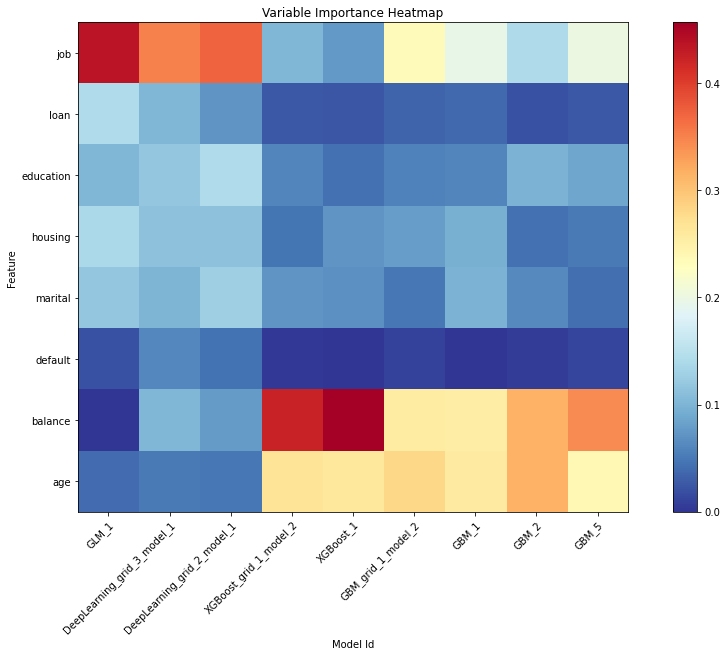

In [26]:
va_plot = aml.varimp_heatmap()

Get the model correlation heatmap

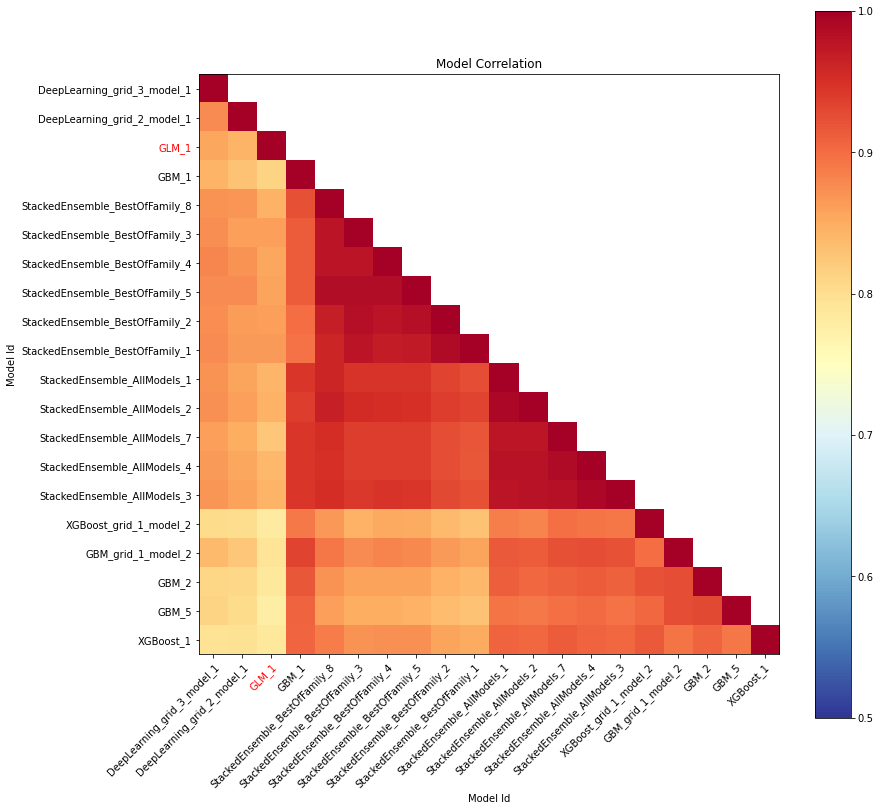

In [27]:
mc_plot = aml.model_correlation_heatmap(test)

Get the shap summary plot

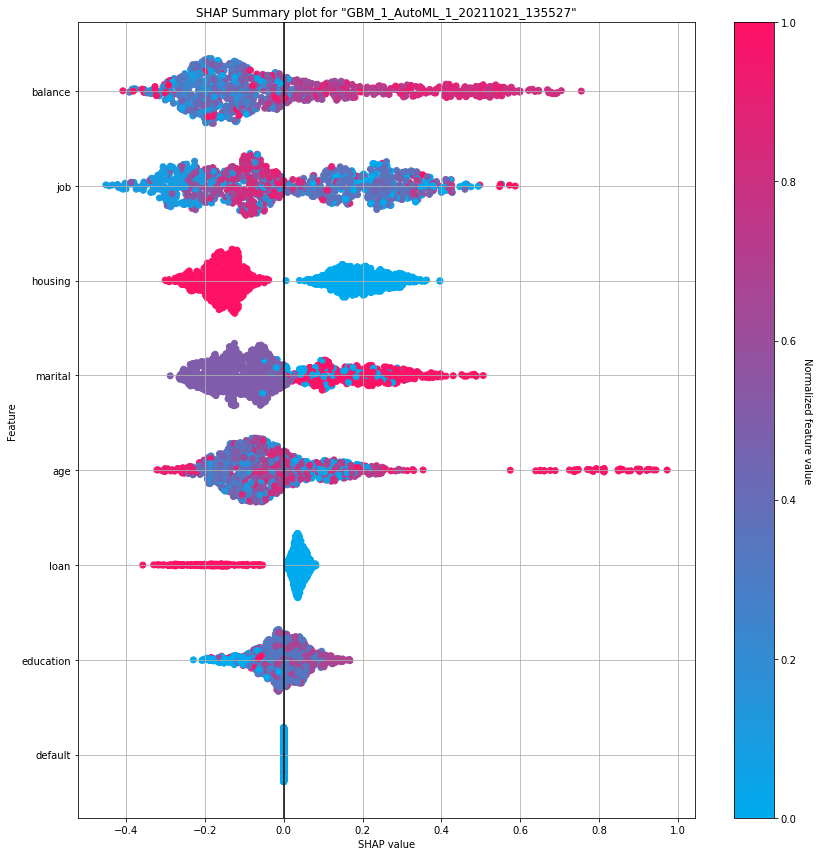

In [28]:
shap_plot = gbm.shap_summary_plot(test)

Get the SHAP local explanation

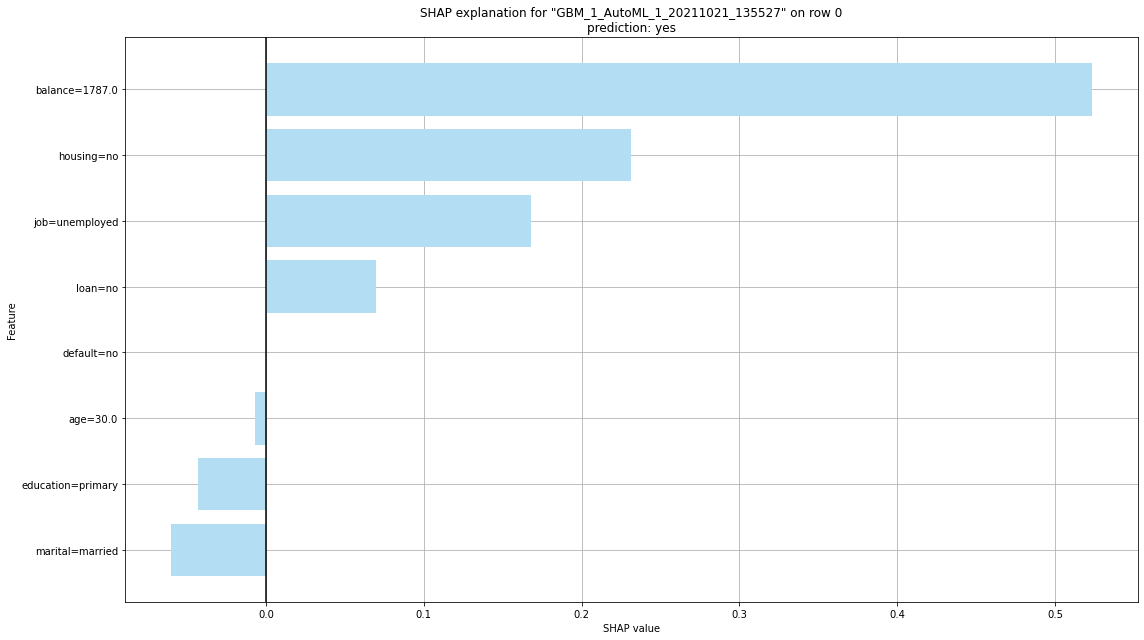

In [29]:
shapr_plot = gbm.shap_explain_row_plot(test, row_index=0)

Now lets get the model metrics based on the evaluation

In [30]:
eval_metrics=model.model_performance(test)
eval_metrics.show()


ModelMetricsBinomial: gbm
** Reported on test data. **

MSE: 0.10649191801519399
RMSE: 0.32633099456716336
LogLoss: 0.3642678509435711
Mean Per-Class Error: 0.39003101240496196
AUC: 0.639953481392557
AUCPR: 0.22044975834968722
Gini: 0.27990696278511407

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.16018039225490938: 


,,no,yes,Error,Rate
0,no,985.0,191.0,0.1624,(191.0/1176.0)
1,yes,105.0,65.0,0.6176,(105.0/170.0)
2,Total,1090.0,256.0,0.2199,(296.0/1346.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.160180,0.305164,136.0
1,max f2,0.062428,0.445658,331.0
2,max f0point5,0.225658,0.290102,63.0
3,max accuracy,0.344425,0.873700,4.0
4,max precision,0.344425,0.500000,4.0
5,max recall,0.039129,1.000000,380.0
6,max specificity,0.366550,0.999150,0.0
7,max absolute_mcc,0.160180,0.186164,136.0
8,max min_per_class_accuracy,0.108378,0.582353,229.0
9,max mean_per_class_accuracy,0.160180,0.609969,136.0



Gains/Lift Table: Avg response rate: 12.63 %, avg score: 11.61 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010401,0.323882,2.827731,2.827731,0.357143,0.343228,0.357143,0.343228,0.029412,0.029412,182.773109,182.773109,0.021759
1,2,0.020059,0.303370,2.436199,2.639216,0.307692,0.313138,0.333333,0.328740,0.023529,0.052941,143.619910,163.921569,0.037635
2,3,0.031204,0.290063,4.222745,3.204762,0.533333,0.295828,0.404762,0.316986,0.047059,0.100000,322.274510,220.476190,0.078741
3,4,0.040119,0.278225,1.979412,2.932462,0.250000,0.282928,0.370370,0.309417,0.017647,0.117647,97.941176,193.246187,0.088735
4,5,0.050520,0.258895,2.262185,2.794464,0.285714,0.268826,0.352941,0.301060,0.023529,0.141176,126.218487,179.446367,0.103762
5,6,0.100297,0.208233,1.536260,2.170022,0.194030,0.230323,0.274074,0.265953,0.076471,0.217647,53.625988,117.002179,0.134314
6,7,0.150074,0.177321,1.654434,1.999010,0.208955,0.190645,0.252475,0.240975,0.082353,0.300000,65.443371,99.900990,0.171599
7,8,0.200594,0.155904,1.746540,1.935425,0.220588,0.166059,0.244444,0.222107,0.088235,0.388235,74.653979,93.542484,0.214766
8,9,0.300149,0.134323,0.768130,1.548253,0.097015,0.145388,0.195545,0.196661,0.076471,0.464706,-23.187006,54.825277,0.188345
9,10,0.400446,0.114868,0.762440,1.351435,0.096296,0.124469,0.170686,0.178579,0.076471,0.541176,-23.755991,35.143512,0.161074


Get the confusion matrix

In [31]:
confusion = eval_metrics.confusion_matrix()
confusion
from sklearn.metrics import confusion_matrix
tested = test.as_data_frame()['y'].values
predictions = preds.as_data_frame()['predict'].values
cm = confusion_matrix(tested, predictions)
tested
labels = ['no', 'yes']
values = [0,1]

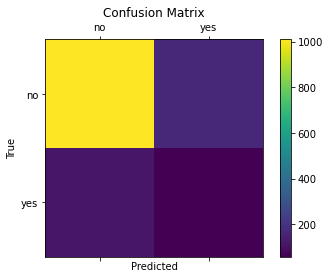

In [32]:
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion Matrix')
fig.colorbar(cax)
ax.set_xticks(values)
ax.set_xticklabels(labels)
ax.set_yticks(values)
ax.set_yticklabels(labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Get the ROC curve plot

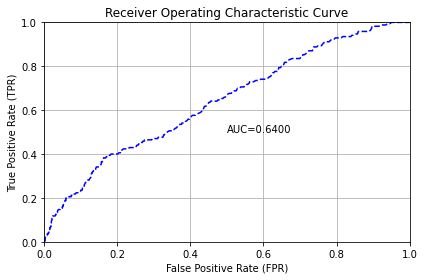

In [33]:
eval_metrics.plot(type = "roc")

Get the precision recall curve plot

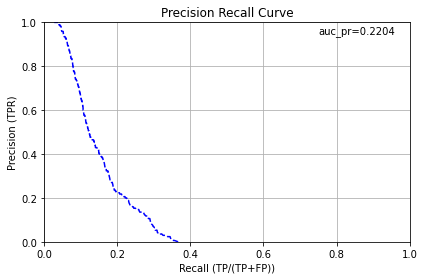

In [34]:
eval_metrics.plot(type = "pr")

Get the learning curve plot

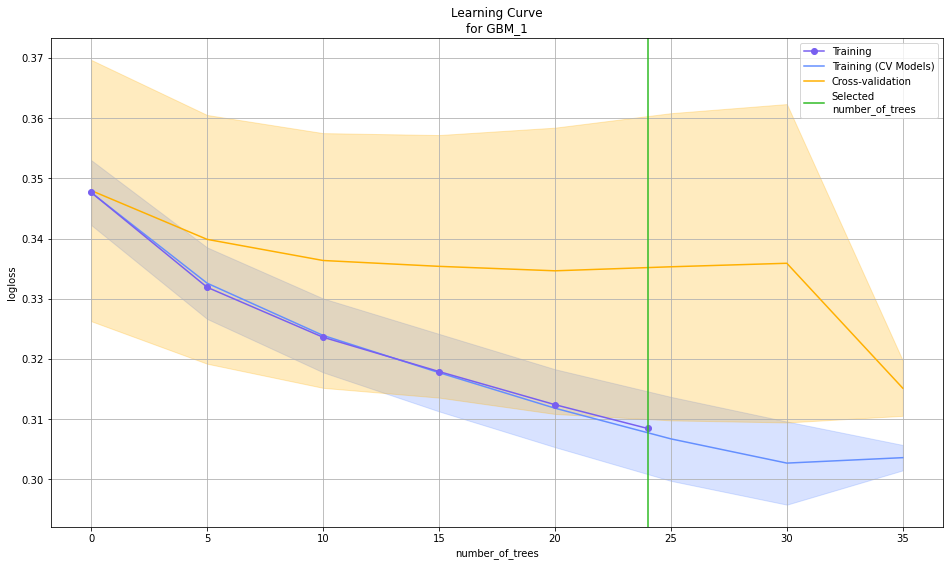

In [35]:
learning_curve_plot = gbm.learning_curve_plot()

Now we format and generate our own metrics

In [36]:
evaluation = {
        'Gini': '{:.6f}'.format(eval_metrics.gini()),
        'MSE': '{:.6f}'.format(eval_metrics.mse()),
        'RMSE': '{:.6f}'.format(eval_metrics.rmse()),
        'LogLoss': '{:.6f}'.format(eval_metrics.logloss()),
        'AUC': '{:.6f}'.format(eval_metrics.auc()),
        'AUCPR': '{:.6f}'.format(eval_metrics.aucpr()),
        'Accuracy': '{:.6f}'.format(eval_metrics.accuracy()[0][1]),
        'Mean Per-Class Error': '{:.6f}'.format(eval_metrics.mean_per_class_error()[0][1]),
        'F1 score': '{:.6f}'.format(eval_metrics.F1()[0][1]),
        'Precision': '{:.6f}'.format(eval_metrics.precision()[0][1]),
        'Sensitivity': '{:.6f}'.format(eval_metrics.sensitivity()[0][1]),
        'Specificity': '{:.6f}'.format(eval_metrics.specificity()[0][1]),
        'Recall': '{:.6f}'.format(eval_metrics.recall()[0][1])
    }

In [37]:
evaluation

{'Gini': '0.279907',
 'MSE': '0.106492',
 'RMSE': '0.326331',
 'LogLoss': '0.364268',
 'AUC': '0.639953',
 'AUCPR': '0.220450',
 'Accuracy': '0.873700',
 'Mean Per-Class Error': '0.390031',
 'F1 score': '0.305164',
 'Precision': '0.500000',
 'Sensitivity': '1.000000',
 'Specificity': '0.999150',
 'Recall': '1.000000'}